In [2]:
# import libraries
from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import files
from google.colab import drive
from PIL import Image
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from __future__ import print_function
import numpy as np
import keras
import os
from glob import glob
from tensorflow.keras import backend as kb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dropout, Conv2D, Concatenate, Conv2DTranspose, Conv3D, MaxPool3D, ConvLSTM2D, LeakyReLU, Activation, BatchNormalization, UpSampling2D, Flatten, TimeDistributed, LSTM, Reshape, Dense, Cropping3D, Permute, Add, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image

TensorFlow 2.x selected.


Using TensorFlow backend.


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# dataset

local_download_path = os.path.expanduser('/content/drive/My Drive/Images')
img = []
for filename in os.listdir(local_download_path): 
  for images in os.listdir(os.path.join(local_download_path,filename)):
    temp = Image.open(os.path.join(os.path.join(local_download_path,filename),images))
    temp = temp.convert('L')
    img.append([images,temp])

img.sort() 

input_x = 64
input_y = 64
output_x = 64
output_y = 64

dataset = []
target = []

for i in range(len(img)):
  dataset.append(np.array(img[i][1].resize((input_x,input_y))))
  target.append(np.array(img[i][1].resize((output_x,output_y))))

dataset = np.stack(np.array(dataset))
target = np.stack(np.array(target))

In [5]:
print(dataset.shape)
print(target.shape)
# input image dimensions
# input_shape = (input_x, input_y, 1)

(955, 64, 64)
(955, 64, 64)


In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 10 # to change
future_target = 1 # to change
STEP = 1 # to change
TRAIN_SPLIT = 850



x_train, y_train = multivariate_data(dataset, target, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP)
x_val, y_val = multivariate_data(dataset, target,
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP)

In [8]:
print ('Single window of past history : {}'.format(x_train.shape))
print ('\n Target window to predict : {}'.format(y_train.shape))
print ('\n Train data size : {}'.format(x_val.shape))
print ('\n Val data size : {}'.format(y_val.shape))

Single window of past history : (840, 10, 64, 64)

 Target window to predict : (840, 1, 64, 64)

 Train data size : (94, 10, 64, 64)

 Val data size : (94, 1, 64, 64)


In [0]:
# Channels last
x_train = np.expand_dims(x_train, 4)
y_train = np.expand_dims(y_train, 4)
x_val = np.expand_dims(x_val, 4)
y_val = np.expand_dims(y_val, 4)

# preprocessing
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_val = x_val.astype('float32')
y_val = y_val.astype('float32')

x_train /= 255
y_train /= 255
x_val /= 255
y_val /= 255

# x_train = x_train*2.0 -1.0
# y_train = y_train*2.0 -1.0
# x_val = x_val*2.0 -1.0
# y_val = y_val*2.0 -1.0


In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(840, 10, 64, 64, 1)
(840, 1, 64, 64, 1)
(94, 10, 64, 64, 1)
(94, 1, 64, 64, 1)


In [0]:
# input_shape = (10,64,64,1) 
# fn=32


# inputs = Input(input_shape)

#   # final_input = UpSampling2D((4, 4), interpolation='bilinear')(inputs)
# crp0 = Cropping3D(((past_history-future_target,0),(0,0),(0,0)))(inputs)
# # final_input = TimeDistributed(UpSampling2D((4,4),interpolation='bilinear'))(crp0)
  
#   #down sampling 
# conv1 = TimeDistributed(Conv2D(  fn, 4, padding = 'same'))(inputs)
# conv1 = TimeDistributed(MaxPooling2D((2,2),padding = 'same'))(conv1)
# act1  = TimeDistributed(LeakyReLU(alpha=0.2))(conv1)
# crp1 = Cropping3D(((past_history-future_target,0),(0,0),(0,0)))(act1)
  
# #(10,32,32,1)

# conv2 = TimeDistributed(Conv2D(2*fn, 4, padding = 'same'))(act1)
# conv2 = TimeDistributed(MaxPooling2D((2,2),padding = 'same'))(conv2)
# conv2 = TimeDistributed(BatchNormalization(momentum=0.8))(conv2)
# act2  = TimeDistributed(LeakyReLU(alpha=0.2))(conv2)
# crp2 = Cropping3D(((past_history-future_target,0),(0,0),(0,0)))(act2)
# #16
  
# conv3 = TimeDistributed(Conv2D(4*fn, 4, padding = 'same'))(act2)
# conv3 = TimeDistributed(MaxPooling2D((2,2),padding = 'same'))(conv3)
# conv3 = TimeDistributed(BatchNormalization(momentum=0.8))(conv3)
# act3  = TimeDistributed(LeakyReLU(alpha=0.2))(conv3)
# crp3 = Cropping3D(((past_history-future_target,0),(0,0),(0,0)))(act3)
# #8
  
# conv4 = TimeDistributed(Conv2D(8*fn, 4, padding = 'same'))(act3)
# conv4 = TimeDistributed(MaxPooling2D((2,2),padding = 'same'))(conv4)
# conv4 = TimeDistributed(BatchNormalization(momentum=0.8))(conv4)
# act4  = TimeDistributed(LeakyReLU(alpha=0.2))(conv4)
# crp4 = Cropping3D(((past_history-future_target,0),(0,0),(0,0)))(act4)
# #4
  
# conv5 = TimeDistributed(Conv2D(8*fn, 4, padding = 'same'))(act4)
# conv5 = TimeDistributed(MaxPooling2D((2,2),padding = 'same'))(conv5)
# conv5 = TimeDistributed(BatchNormalization(momentum=0.8))(conv5)
# act5  = TimeDistributed(LeakyReLU(alpha=0.2))(conv5)
# crp5 = Cropping3D(((past_history-future_target,0),(0,0),(0,0)))(act5)
# #2
  
# conv6 = TimeDistributed(Conv2D(8*fn, 4, padding = 'same'))(act5)
# conv6 = TimeDistributed(MaxPooling2D((2,2),padding = 'same'))(conv6)
# conv6 = TimeDistributed(BatchNormalization(momentum=0.8))(conv6)
# act6  = TimeDistributed(LeakyReLU(alpha=0.2))(conv6)
# # crp6 = Cropping3D(((past_history-future_target,0),(0,0),(0,0)))(act6)
# #1
  
# # conv7 = TimeDistributed(Conv2D(8*fn, 4, padding = 'same'))(act6)
# # conv7 = TimeDistributed(MaxPooling2D((2,2),padding = 'same'))(conv7)
# # conv7 = TimeDistributed(BatchNormalization(momentum=0.8))(conv7)
# # act7  = TimeDistributed(LeakyReLU(alpha=0.2))(conv7)
  
#   # conv8 = Conv2D(8*fn, 4, strides=2, padding = 'same')(act7)
#   # conv8 = BatchNormalization(momentum=0.8)(conv8)
#   # act8  = LeakyReLU(alpha=0.2)(conv8)
# tm1 = Reshape((past_history,8*fn))(act6)
# lst1 = LSTM(64, return_sequences=True, activation='relu')(tm1)
# lst2 = LSTM(64, return_sequences=True, activation='relu')(lst1)
# lst3 = LSTM(64, return_sequences=True, activation='relu')(lst2)
# lst4 = LSTM(64, activation='relu')(lst3)
# d1 = Dense(8*fn*future_target)(lst4) #target_size*ft_size
# r1 = Reshape((future_target,1,1,8*fn))(d1)

#   #up sampling
# # conv9 = TimeDistributed(Conv2DTranspose(8*fn, 4, strides=2, padding='same'))(r1)
# conv9 = TimeDistributed(UpSampling2D((2, 2),interpolation='bilinear'))(r1)
# conv9 = TimeDistributed(Conv2D(8*fn, 4, padding = 'same'))(conv9)
# # conv9 = TimeDistributed(BatchNormalization(momentum=0.8))(conv9)
# conv9 = TimeDistributed(Dropout(rate=0.5))(conv9)
# conv9 = Concatenate(axis = 4)([conv9,crp5])
# act9  = TimeDistributed(Activation('relu'))(conv9)

# #(1,2,2,64)  
  
# # conv10 = TimeDistributed(Conv2DTranspose(8*fn, 4, strides=2, padding='same'))(act9)
# conv10 = TimeDistributed(UpSampling2D((2, 2),interpolation='bilinear'))(act9)
# conv10 = TimeDistributed(Conv2D(8*fn, 4, padding = 'same'))(conv10)
# conv10 = TimeDistributed(BatchNormalization(momentum=0.8))(conv10)
# conv10 = TimeDistributed(Dropout(rate=0.5))(conv10)
# conv10 = Concatenate(axis = 4)([conv10,crp4])
# act10  = TimeDistributed(Activation('relu'))(conv10)

# #4 
  
# # conv11 = TimeDistributed(Conv2DTranspose(8*fn, 4, strides=2, padding='same'))(act10)
# conv11 = TimeDistributed(UpSampling2D((2, 2),interpolation='bilinear'))(act10)
# conv11 = TimeDistributed(Conv2D(8*fn, 4, padding = 'same'))(conv11)
# conv11 = TimeDistributed(BatchNormalization(momentum=0.8))(conv11)
# conv11 = TimeDistributed(Dropout(rate=0.5))(conv11)
# conv11 = Concatenate(axis = 4)([conv11,crp3])
# act11  = TimeDistributed(Activation('relu'))(conv11)
  
# #8
  
# # conv12 = TimeDistributed(Conv2DTranspose(4*fn, 4, strides=2, padding='same'))(act11)
# conv12 = TimeDistributed(UpSampling2D((2,2),interpolation='bilinear'))(act11)
# conv12 = TimeDistributed(Conv2D(4*fn, 4, padding = 'same'))(conv12)
# # conv12 = TimeDistributed(BatchNormalization(momentum=0.8))(conv12)
# conv12 = Concatenate(axis = 4)([conv12,crp2])
# act12  = TimeDistributed(Activation('relu'))(conv12)

# #16  
  
# # conv13 = TimeDistributed(Conv2DTranspose(2*fn, 4, strides=2, padding='same'))(act12)
# conv13 = TimeDistributed(UpSampling2D((2,2),interpolation='bilinear'))(act12)
# conv13 = TimeDistributed(Conv2D(2*fn, 4, padding = 'same'))(conv13)
# conv13 = TimeDistributed(BatchNormalization(momentum=0.8))(conv13)
# conv13 = Concatenate(axis = 4)([conv13,crp1])
# act13  = TimeDistributed(Activation('relu'))(conv13)
  
# #32

# # conv14 = TimeDistributed(Conv2DTranspose(fn, 4, strides=2, padding='same'))(act13)
# conv14 = TimeDistributed(UpSampling2D((2, 2),interpolation='bilinear'))(act13)
# conv14 = TimeDistributed(Conv2D(fn, 4, padding = 'same'))(conv14)
# conv14 = TimeDistributed(BatchNormalization(momentum=0.8))(conv14)
# # conv14 = Concatenate(axis = 4)([conv14,crp1])
# act14  = TimeDistributed(Activation('relu'))(conv14)
  
# #64

# # conv15 = TimeDistributed(Conv2DTranspose( 1, 4, strides=2, padding='same'))(act14)
# # conv15 = TimeDistributed(UpSampling2D((2, 2),interpolation='bilinear'))(act14)
# # conv15 = TimeDistributed(Conv2D(fn, 4, padding = 'same'))(conv15)
# # conv15 = TimeDistributed(BatchNormalization(momentum=0.8))(conv15)
# # act15  = TimeDistributed(Activation('relu'))(conv15)


# # conv16 = TimeDistributed(Conv2DTranspose( fn, 4, strides=2, padding='same'))(act15)
# # conv16 = TimeDistributed(UpSampling2D((2, 2),interpolation='bilinear'))(act15)
# # conv16 = TimeDistributed(Conv2D(fn, 4, padding = 'same'))(conv16)
# # # conv16 = TimeDistributed(BatchNormalization(momentum=0.8))(conv16)
# # act16  = TimeDistributed(Activation('relu'))(conv16)
  
  
  
# # conv17 = TimeDistributed(Conv2DTranspose( input_shape[-1], 1, strides=2, padding='same'))(act16)
# # conv17 = TimeDistributed(UpSampling2D((2, 2),interpolation='bilinear'))(act16)
# # conv17 = TimeDistributed(Conv2D(fn, 4, padding='same'))(conv17)
# # conv17 = TimeDistributed(BatchNormalization(momentum=0.8))(conv17)
# # conv17 = TimeDistributed(Activation('relu'))(conv17)

# conv18 = TimeDistributed(Conv2D(1, 1, padding = 'same'))(conv14)
# conv18 = TimeDistributed(Activation('sigmoid'))(conv18)
# # conv18 = Add()([conv18,final_input])
  
# output = conv18
# generator = Model(inputs = inputs, outputs = conv18)
# generator.summary()


In [0]:
# input_shape = (256,256,1) # to change
# generator = similar_unet(input_shape = (input_x, input_y, 1), fn=64)
# generator.summary()

In [12]:
input_shape = (past_history, input_x, input_y, 1) 

inputs = Input(input_shape)

conv1 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(inputs)
conv1 = BatchNormalization() (conv1)

conv2 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(conv1)
conv2 = BatchNormalization() (conv2)

conv3 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(conv2)
conv3 = BatchNormalization() (conv3)

conv4 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(conv3)
conv4 = BatchNormalization() (conv4)

conv5 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True)(conv4)
conv5 = BatchNormalization() (conv5)

conv6 = ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same')(conv5)

conv7 = Conv2D(filters=1, kernel_size=(1, 1),activation='sigmoid', padding='same', data_format='channels_last')(conv6)
output = Reshape((1,64,64,1))(conv7)

generator = Model(inputs = inputs, outputs = output)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 64, 64, 1)]   0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 10, 64, 64, 64)    150016    
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 64, 64, 64)    256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 64, 64, 64)    295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 64, 64, 64)    256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 64, 64, 64)    295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 64, 64, 64)    256   

In [13]:
def build_discriminator(input_shape, output_shape, fn):
  img_A = Input(shape=input_shape)
  img_B = Input(shape=output_shape)
  # scale_img = TimeDistributed(UpSampling2D((2, 2), interpolation='bilinear'))(img_A)
  p1 = Cropping3D(((past_history-future_target,0),(0,0),(0,0)))(img_A)
  r1 = Reshape((64,64,1))(p1)
  c1 = Conv2D(  fn, kernel_size=3, padding="same")(r1)
  # p2 = Permute((4,2,3,1))(img_B)
  r2 = Reshape((64,64,future_target))(img_B)
  c2 = Conv2D(  fn, kernel_size=3, padding="same")(r2)
  x = Concatenate(axis=-1)([c1, c2])
  
  x = Conv2D(  fn, kernel_size=3, strides=2, padding="same")(x)
  x = Activation('relu')(x)
  x = Conv2D(fn, kernel_size=3, padding="same")(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Activation('relu')(x)
  # x = Conv2D(fn, kernel_size=3, strides=2, padding="same")(x)
  # x = BatchNormalization(momentum=0.8)(x)
  # x = Activation('relu')(x)
  #x = Conv2D(fn, kernel_size=3, strides=1, padding="same")(x)
  #x = BatchNormalization(momentum=0.8)(x)
  #x = Activation('relu')(x)
  x = Conv2D(   1, kernel_size=3, padding="same",  activation='sigmoid')(x)
  
  model = Model([img_A, img_B], x)

  return model
output_shape = (1,output_x, output_y, 1)
discriminator = build_discriminator(input_shape, output_shape, fn = 64)
discriminator.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 64, 64,  0                                            
__________________________________________________________________________________________________
cropping3d (Cropping3D)         (None, 1, 64, 64, 1) 0           input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1, 64, 64, 1 0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 64, 64, 1)    0           cropping3d[0][0]                 
____________________________________________________________________________________________

# Combine

In [0]:
def my_loss(y_actual,y_predicted):
  loss_value =  kb.exp(1-kb.minimum(kb.abs(y_actual),kb.abs(y_predicted)))* kb.square(y_actual-y_predicted)
  return loss_value

In [0]:
# Algorithm of optimization
optimizer = optimizers.Adam(0.004, 0.5)

# Compile the discriminator
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', \
                      optimizer=optimizer, metrics=['accuracy'])


# Input images and their conditioning images
img_x = Input(shape=input_shape) 
# The generator 
img_y = generator(img_x)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator([img_x, img_y])

# The combined model  (soptimizernerator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(img_x, (valid,img_y))
# combined.compile(loss=['binary_crossentropy', my_loss], \
#                  loss_weights=[1, 100], optimizer='adam',my_trics=['accuracy'])
combined.compile(loss=['binary_crossentropy', my_loss], \
                  optimizer='adam', metrics=['accuracy'])
# 'mae' is for "mean absolute error"


In [0]:
def show_imgs(*list_images):
  import matplotlib.pyplot as plt 
  from IPython.display import clear_output
  c = len(list_images)
  r = len(list_images[0])
  fig = plt.figure(figsize=(3*c,3*r))
  axs = fig.subplots(r, c)
  for i in range(r):
    for j in range(c):
      img = list_images[j][i]
      # img = (128 * img + 128).clip(0,255).astype(np.uint8)
      axs[i,j].imshow(img[:,:,0],'gray')
      axs[i,j].axis('off')
          
  clear_output(wait=True)
  plt.show()
  

In [0]:
generator.load_weights('/content/drive/My Drive/models/generator_weights_64.h5')
discriminator.load_weights('/content/drive/My Drive/models/discriminator_weights_64.h5')
combined.load_weights('/content/drive/My Drive/models/combined_weights_64.h5')

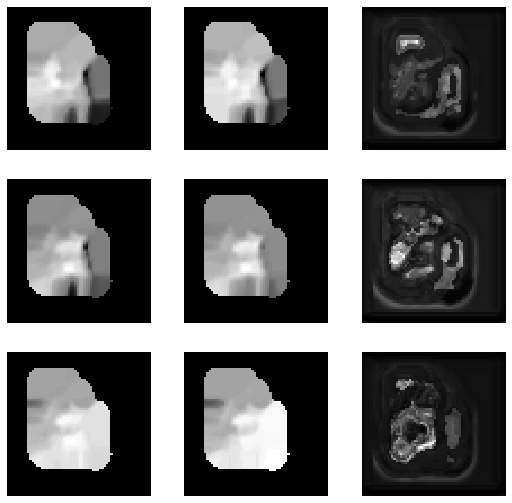

	Generated after 19 epoches, loss = 0.001679, d_loss = 0.00

   19/  839 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000412, my loss: 0.013764]

In [18]:
batch_size = 1
epochs = 20
e_loss = 0
e_acc = 0
loss_history = []
d_loss_history =[]

# generator.load_weights('/content/drive/My Drive/models/generator_weights_64.h5')
# discriminator.load_weights('/content/drive/My Drive/models/discriminator_weights_64.h5')
# combined.load_weights('/content/drive/My Drive/models/combined_weights_64.h5')

train_steps = len(x_train) // batch_size # train_files = 650
valid_steps = len(x_val) // batch_size # valid_files = 83
 

# Adversarial ground truths
valid = np.ones((batch_size, 32,32,1))
fake = np.zeros((batch_size, 32,32,1))

train_inds = list(range(len(x_train))) # 650
for epoch in range(epochs):
  
  
  # ---------------------
  #  Show generated images
  # ---------------------

  # generate images
  img_x, img_y= x_val[[0,5,10]], y_val[[0,5,10]] # take 5 examples

  gen_imgs = generator.predict(img_x)

  # show generated images
  show_imgs(img_x[:,9],img_y[:,0], gen_imgs[:,0]) ### to define
  loss_history.append(e_loss/train_steps)
  d_loss_history.append(e_acc/train_steps)
  print('\tGenerated after %d epoches, loss = %5f, d_loss = %.2f'% (epoch, e_loss/train_steps, e_acc/train_steps))
  print()
  e_loss = 0
  e_acc = 0
  np.random.shuffle(train_inds)
  for index in range(train_steps):

    idx = train_inds[(index*batch_size):(index*batch_size+batch_size)]

    # imgs = [y_train[el] for el in idx]
    # msk = [x_train[el] for el in idx]
    imgs = y_train[[idx]]
    msk = x_train[[idx]]
    # generate a batch of new images
    gen_imgs = generator.predict(msk)
    
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch([msk, imgs], valid)
    d_loss_fake = discriminator.train_on_batch([msk, gen_imgs], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  
    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator (wants discriminator to mistake images as real)
    discriminator.trainable = False
    g_loss = combined.train_on_batch(msk, [valid, imgs])

    # Print the progress
    print("\r%5d/%5d [D loss: %5f, acc.: %.2f%%] [G loss: %5f, my loss: %5f]" % (epoch, index, d_loss[0], 100*d_loss[1], g_loss[1], g_loss[2]) , end='')
    e_loss += g_loss[1]
    e_acc += d_loss[0] #discriminator loss


# Save weights after done    
generator.save_weights('/content/drive/My Drive/models/generator_weights_64.h5')
# generator.save('/content/drive/My Drive/models/generator_model.h5')
discriminator.save_weights('/content/drive/My Drive/models/discriminator_weights_64.h5')
# discriminator.save('/content/drive/My Drive/models/discriminator_model.h5')
combined.save_weights('/content/drive/My Drive/models/combined_weights_64.h5')
# combined.save('/content/drive/My Drive/models/combined_model.h5')

#8

In [0]:
predicted = generator.predict(x_train)

In [0]:
plt.imshow(predicted[260,:,:,0],'gray')

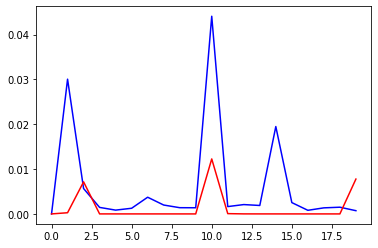

In [0]:
ep = range(len(loss_history))
plt.plot(ep,loss_history,'b',label='generator loss')
plt.plot(ep,d_loss_history,'r',label='discriminator loss')
plt.show()

In [0]:
generator.load_weights('/content/drive/My Drive/models/generator_weights.h5')
#generator.save('/content/drive/My Drive/models/generator_model.h5')
discriminator.load_weights('/content/drive/My Drive/models/discriminator_weights.h5')
#discriminator.save('/content/drive/My Drive/models/discriminator_model.h5')
combined.load_weights('/content/drive/My Drive/models/combined_weights.h5')
#combined.save('/content/drive/My Drive/models/combined_model.h5')